In [1]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
import os
import time
import numpy as np
import gc
from tensorflow.keras.models import model_from_json
!pip install tqdm
!pip install h5py
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [2]:
def scale(x):

    return (x - np.mean(x)) / np.std(x)

In [3]:
def preprocess(x):
    
    return x[:,:,:int(0.75*x.shape[2])]

In [4]:
u = preprocess(scale(loadmat('u_F_xyz_T1.mat')["u_F"]))
v = preprocess(scale(loadmat('v_F_xyz_T1.mat')["v_F"]))
w = preprocess(scale(loadmat('w_F_xyz_T1.mat')["w_F"]))
tau_12 = preprocess(scale(loadmat('tau12_xyz_T1.mat')["tau12"]))

### 1. Generae Input datasets

#### 1.1 Create x_base with dxdxd cubes

In [5]:
x = np.array([u, v, w])
x = np.transpose(x, [1, 2, 3, 0])
x_base = np.pad(x, ((3,3), (3,3), (3,3), (0,0)), 'constant', constant_values = 0)

In [6]:
sample = []
size = 3
tau_12_base = []

for i in tqdm_notebook(range(size, x_base.shape[0] - size)):
    for j in range(size, x_base.shape[1] - size):
        for k in range(size, x_base.shape[2] - size):
            sample.append(x_base[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
            tau_12_base.append(tau_12[i - size][j - size][k - size])

x_base = np.stack(sample, axis = 0)
tau_12_base = np.array(tau_12_base)
print(x_base.shape)

del sample
gc.collect()


(784896, 7, 7, 7, 3)


7

#### 1.2 Create x_mod with dxmxn cubes

In [7]:
x_mod_1 = np.pad(x,((5,5), (3,3), (2,2), (0,0)), "constant", constant_values = 0)

In [8]:
sample = []
size_x = 5
size_y = 3
size_z = 2
tau_12_mod_1 = []

for i in tqdm_notebook(range(size_x, x_mod_1.shape[0] - size_x)):
    for j in range(size_y, x_mod_1.shape[1] - size_y):
        for k in range(size_z, x_mod_1.shape[2] - size_z):
            sample.append(x_mod_1[i - size_x: i + size_x + 1, j - size_y: j + size_y + 1, k - size_z: k + size_z + 1, :])
            tau_12_mod_1.append(tau_12[i - size_x][j - size_y][k - size_z])

x_mod_1 = np.stack(sample, axis = 0)
tau_12_mod_1 = np.array(tau_12_mod_1)
print(x_mod_1.shape)

del sample
gc.collect()


(784896, 11, 7, 5, 3)


0

In [9]:
x_mod_2 = np.pad(x,((7,7), (5,5), (1,1), (0,0)), "constant", constant_values = 0)

In [10]:
sample = []
size_x = 7
size_y = 5
size_z = 1
tau_12_mod_2 = []

for i in tqdm_notebook(range(size_x, x_mod_2.shape[0] - size_x)):
    for j in range(size_y, x_mod_2.shape[1] - size_y):
        for k in range(size_z, x_mod_2.shape[2] - size_z):
            sample.append(x_mod_2[i - size_x: i + size_x + 1, j - size_y: j + size_y + 1, k - size_z: k + size_z + 1, :])
            tau_12_mod_2.append(tau_12[i - size_x][j - size_y][k - size_z])

x_mod_2 = np.stack(sample, axis = 0)
tau_12_mod_2 = np.array(tau_12_mod_2)
print(x_mod_2.shape)

del sample
del x
gc.collect()


(784896, 15, 11, 3, 3)


0

### 2. Build Model 

In [11]:
class DNN(object):
    
    def __init__(self, activation, x_train, y_train, epochs, batch_size, input_shape, val_split, initializer):
        self.activation = activation
        self.x_train = x_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.val_split = val_split
        self.initializer = initializer
        
        pass 
    
    def create_model(self):
        model = keras.Sequential([
            tf.keras.layers.Flatten(input_shape = self.input_shape),
            tf.keras.layers.Dense(128, 
                             activation = self.activation,
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, 
                             activation = self.activation,
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, 
                             activation = self.activation,
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dense(1)
        ])
        
        return model
    
    def callbacks(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               min_delta = 0.001,
                                               patience = 0,
                                               verbose = 0)
        
        return early_stopping
    
    def run_model(self):
        model = self.create_model()
        model.compile(optimizer = tf.train.AdamOptimizer(), 
              loss = "mse")
            
        history = model.fit(self.x_train, self.y_train, 
                    epochs = self.epochs, 
                    validation_split = self.val_split, 
                    batch_size =  self.batch_size,
                    verbose = 0)
                    #callbacks = [self.callbacks()])
        
        return history, model

### 3. Run Model

Using x_base with box size 7x7x7x3 as input
R^2: 0.6631
Correlation: 0.8467

Using x_mod_1 with box size 11x7x5x3 as input
R^2: 0.6760
Correlation: 0.8438

Using x_mod_2 with box size 15x11x3x3 as input
R^2: 0.6523
Correlation: 0.8421



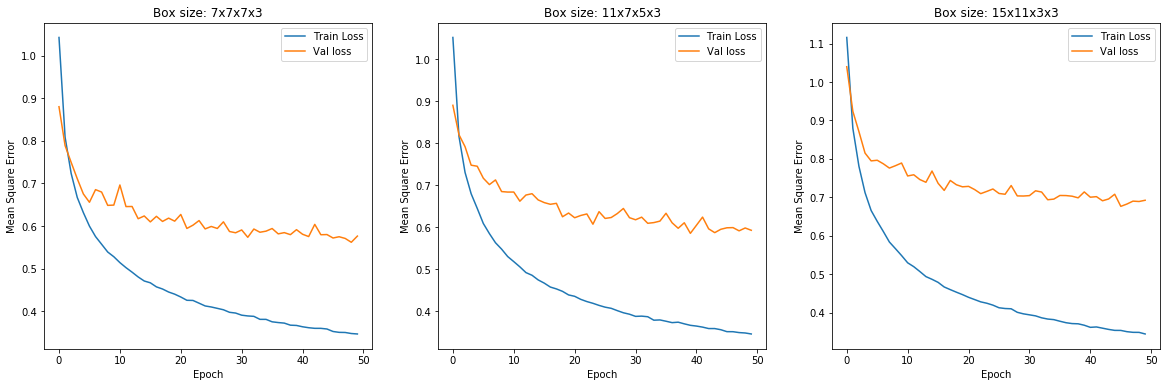

In [12]:
activation = tf.nn.relu
epochs = 50
initializer = tf.glorot_uniform_initializer
batch_size = 1000
val_split = 0.2

datasets = [(x_base, tau_12_base, "x_base", "7x7x7x3"), (x_mod_1, tau_12_mod_1, "x_mod_1", "11x7x5x3"), 
            (x_mod_2, tau_12_mod_2, "x_mod_2", "15x11x3x3")]
fig = plt.figure(figsize = (20, 6))
results = {}
i = 1
for (x, y, name, size) in datasets:
    print("Using " + name + " with box size " + size + " as input")
    mask =  np.random.rand(x.shape[0]) < 0.80
    y_train, y_test = y[mask], y[~mask]
    x_train, x_test = x[mask,:,:,:,:], x[~mask,:,:,:,:]

    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3], x_train.shape[4])
    model = DNN(activation, x_train, y_train, epochs, batch_size, input_shape, val_split, initializer)        
    history, model = model.run_model()
        
    del x_train
    del y_train
    gc.collect()
        
    fig.add_subplot(1, len(datasets), i)
    plt.plot(history.epoch, np.array(history.history['loss']), label = 'Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.title(str("Box size: " + size))
    plt.legend()

    y_pred = model.predict(x_test).flatten()
    y_true = y_test
    print("R^2: %.4f" % r2_score(y_true, y_pred))
    print("Correlation: %.4f\n" % np.corrcoef(y_pred, y_true)[0, 1])
    results[np.corrcoef(y_pred, y_true)[0, 1]] = (x, name)
        
    del x_test
    del y_test
    del x
    del y_true
    del y_pred
    del model
    gc.collect()
    i += 1

plt.show()